# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
import time

In [3]:
df_data = t.from_pkl(f'{processed_data_path}/df_clean.pkl')

df_data.shape
df_data.head(3)

(97053, 8)

,make,model,year,price,transmission,mileage,fuelType,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,1.4


In [4]:
df_data.insert(0, 'car', df_data['make'] + '__' + df_data['model'])
df_data = df_data.drop(columns=['make', 'model'])
df_data.groupby(['car']).size().sort_values(ascending=False).head(10)

car
Ford__Fiesta       6489
Vw__Golf           4766
Ford__Focus        4544
Merc__C Class      3689
Vauxhall__Corsa    3279
Vw__Polo           3230
Vauxhall__Astra    2641
Merc__A Class      2468
Bmw__3 Series      2409
Ford__Kuga         2207
dtype: int64

In [5]:
df_1_car = df_data.loc[ (df_data['car'] == 'Ford__Fiesta') ].drop(columns=['car']).copy()
df_1_car.head(3)

mileage_5k = ((df_1_car['mileage'] / 5000).round(0) * 5000).astype(int)
df_grp = df_1_car.drop(columns='mileage').groupby(['year', 'transmission', mileage_5k, 'fuelType', 'engineSize'])['price'].agg([len, np.mean, np.std, m.mad])

'mean group size: ', df_grp['len'].mean()
'price mad in 5k groups: ', df_grp['mad'].mean()
'price std in 5k groups: ', df_grp['std'].mean()

,year,price,transmission,mileage,fuelType,engineSize
21449,2017,12000,Automatic,15944,Petrol,1.0
21452,2019,17500,Manual,10460,Petrol,1.5
21453,2019,16500,Automatic,1482,Petrol,1.0


('mean group size: ', 10.655172413793103)

('price mad in 5k groups: ', 326.5094316074065)

('price std in 5k groups: ', 696.6597777424047)

# Encode

In [6]:
# df_1_car['age'] = (2022 - df_1_car['year'])
# df_1_car['mileage_k'] = df_1_car['mileage']/ 1000
# df_1_car['price_k'] = df_1_car['price']/ 1000
# df_1_car.drop(columns=['year', 'mileage', 'price'], inplace=True)

m.ordinalEncode(df_1_car, ['transmission', 'fuelType'])
df_1_car.head(3)

,year,price,transmission,mileage,fuelType,engineSize
21449,2017,12000,0,15944,1,1.0
21452,2019,17500,1,10460,1,1.5
21453,2019,16500,0,1482,1,1.0


## X, y

In [7]:
df_train = df_1_car
X, y  = df_train.drop(columns='price').copy(), df_train['price'].copy()

y.shape
X.shape
X.columns
X.head(3)
y.head(3)

(6489,)

(6489, 5)

Index(['year', 'transmission', 'mileage', 'fuelType', 'engineSize'], dtype='object')

,year,transmission,mileage,fuelType,engineSize
21449,2017,0,15944,1,1.0
21452,2019,1,10460,1,1.5
21453,2019,0,1482,1,1.0


21449    12000
21452    17500
21453    16500
Name: price, dtype: int64

# Train model

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale, normalize, scale, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import make_pipeline

## First Run

,model,params,n_folds,R2_mean,R2_std,#1,time,d,k
35,LinearRegression,,6,0.851,0.046,12,0.1,3,55
81,Ridge,'alpha': 0.25,6,0.825,0.011,11,0.1,4,85
36,Ridge,'alpha': 0.25,6,0.822,0.005,10,0.1,3,55
50,LinearRegression,,6,0.811,0.016,9,0.1,4,25
5,LinearRegression,,6,0.807,0.016,8,0.0,2,15
95,LinearRegression,,6,0.773,0.022,7,0.1,5,15
6,Ridge,'alpha': 0.25,6,0.770,0.016,6,0.0,2,15
96,Ridge,'alpha': 0.25,6,0.728,0.017,5,0.0,5,15
98,Lasso,'alpha': 0.5,6,0.390,0.010,4,0.3,5,15
68,Lasso,'alpha': 0.5,6,0.389,0.010,3,0.7,4,55


CPU times: user 1min 54s, sys: 3min 11s, total: 5min 5s
Wall time: 29.4 s


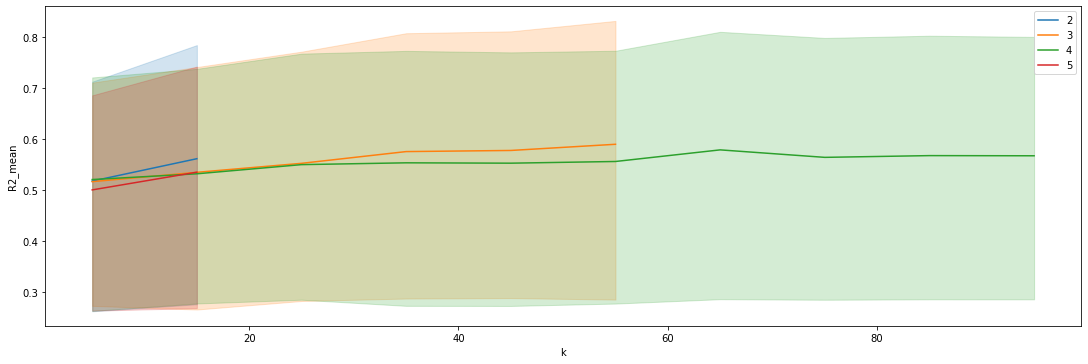

In [9]:
%%time

all_res = []
res_count = 0

cv = RepeatedKFold(n_splits=6, n_repeats=1)
metrics = [r2_score]

models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.25, 0.75] ],
    *[ (Lasso, {'random_state': RS, 'alpha' : a}) for a in [0.5, 0.75] ],
]

y_scalers = make_pipeline(MinMaxScaler(), StandardScaler())
y_scaled = pd.Series(index = y.index, data=y_scalers.fit_transform(y.values.reshape(-1,1)).reshape(-1))

for i_degree in range(2, 6):
    X_poly = m.polynomialFeatures(X, i_degree)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]), with_mean=False)
    X_poly_scaled = X_poly
    
    for k in range (5, min(X_poly_scaled.shape[1], 100), 10):
        select_K = SelectKBest(f_regression, k = k)
        X_poly_scaled_select_k = pd.DataFrame(data = select_K.fit_transform(X_poly_scaled, y), columns = select_K.get_feature_names_out(), index = X_poly_scaled.index)

        res = t.grid_exec(
            lambda model: m.cv_regression(model, cv, X_poly_scaled_select_k, y_scaled, metrics), 
            models_and_params, 
        )

        for r in res:                
            r['d'] = i_degree
            r['k'] = k

        all_res.extend(res)

        res_count += 1
        if res_count % 10 == 0:
            df_res = pd.DataFrame(all_res)
            m.display_stats(
                df_res.groupby(['d', 'model'], group_keys=False).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
            )
            
ax = t.get_ax(0.25)
for d in df_res['d'].unique():
    df_plt = df_res.loc[df_res['d'] == d]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)

## Best 2 models

,model,params,n_folds,R2_mean,R2_std,#1,time,d,k
84,LinearRegression,,6,0.856,0.038,12,0.1,4,70
42,LinearRegression,,6,0.851,0.046,11,0.1,3,55
112,Ridge,'alpha': 0.1,6,0.846,0.011,10,0.1,4,115
205,Ridge,'alpha': 0.1,6,0.840,0.010,9,0.1,5,145
43,Ridge,'alpha': 0.1,6,0.828,0.006,8,0.1,3,55
9,LinearRegression,,6,0.817,0.012,7,0.0,2,20
135,LinearRegression,,6,0.813,0.021,6,0.2,5,30
225,LinearRegression,,6,0.812,0.024,5,0.2,6,35
289,Ridge,'alpha': 0.1,6,0.798,0.011,4,0.1,6,140
10,Ridge,'alpha': 0.1,6,0.780,0.012,3,0.0,2,20


CPU times: user 3min 31s, sys: 5min 47s, total: 9min 19s
Wall time: 54.8 s


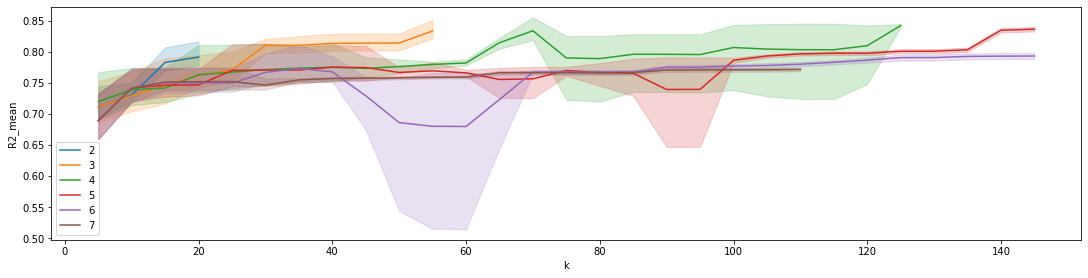

In [20]:
%%time

all_res = []
res_count = 0

cv = RepeatedKFold(n_splits=6, n_repeats=1)
metrics = [r2_score]

models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.1, 0.25] ]
]

y_scalers = make_pipeline(MinMaxScaler(), StandardScaler())
y_scaled = pd.Series(index = y.index, data=y_scalers.fit_transform(y.values.reshape(-1,1)).reshape(-1))

for i_degree in range(2, 8):
    X_poly = m.polynomialFeatures(X, i_degree)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]), with_mean=False)
    X_poly_scaled = X_poly
    
    for k in range (5, min(X_poly_scaled.shape[1], 150), 5):
        select_K = SelectKBest(f_regression, k = k)
        X_poly_scaled_select_k = pd.DataFrame(data = select_K.fit_transform(X_poly_scaled, y), columns = select_K.get_feature_names_out(), index = X_poly_scaled.index)

        res = t.grid_exec(
            lambda model: m.cv_regression(model, cv, X_poly_scaled_select_k, y_scaled, metrics), 
            models_and_params, 
        )

        for r in res:                
            r['d'] = i_degree
            r['k'] = k

        all_res.extend(res)

        res_count += 1
        if res_count % 10 == 0:
            df_res = pd.DataFrame(all_res)
            m.display_stats(
                df_res.groupby(['d', 'model'], group_keys=False).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
            )
            
ax = t.get_ax(0.25)
for d in df_res['d'].unique():
    df_plt = df_res.loc[(df_res['d'] == d) & (df_res['R2_mean'] > 0)]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)

## Tuning

,model,params,n_folds,R2_mean,R2_std,#1,time,d,k
850,Ridge,'alpha': 0.025,40,0.864,0.010,6,1.5,5,251
78,LinearRegression,,40,0.858,0.036,5,1.0,4,70
15,LinearRegression,,40,0.852,0.048,4,0.8,3,55
244,Ridge,'alpha': 0.025,40,0.850,0.033,3,0.7,4,125
13,Ridge,'alpha': 0.025,40,0.839,0.011,2,0.4,3,54
285,LinearRegression,,40,0.803,0.051,1,1.0,5,63


CPU times: user 1h 26min 3s, sys: 2h 18min 41s, total: 3h 44min 44s
Wall time: 18min 56s


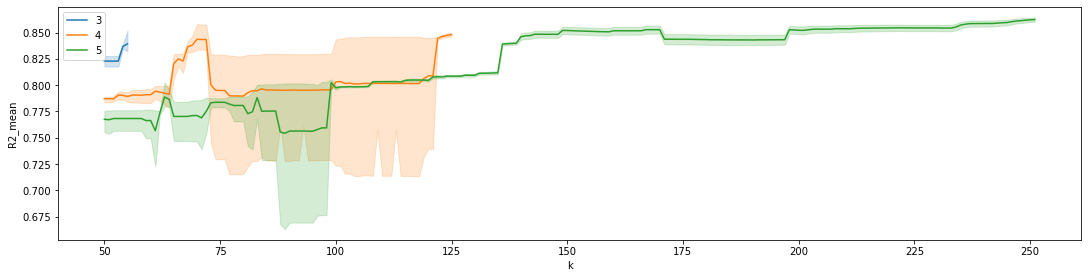

In [40]:
%%time

all_res = []
res_count = 0

cv = RepeatedKFold(n_splits=8, n_repeats=5)
metrics = [r2_score]

models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.025, 0.05] ]
]

y_scalers = make_pipeline(MinMaxScaler(), StandardScaler())
y_scaled = pd.Series(index = y.index, data=y_scalers.fit_transform(y.values.reshape(-1,1)).reshape(-1))

for i_degree in range(3, 6):
    X_poly = m.polynomialFeatures(X, i_degree)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]), with_mean=False)
    X_poly_scaled = X_poly
    
    for k in range (50, X_poly_scaled.shape[1]):
        select_K = SelectKBest(f_regression, k = k)
        X_poly_scaled_select_k = pd.DataFrame(data = select_K.fit_transform(X_poly_scaled, y), columns = select_K.get_feature_names_out(), index = X_poly_scaled.index)

        res = t.grid_exec(
            lambda model: m.cv_regression(model, cv, X_poly_scaled_select_k, y_scaled, metrics), 
            models_and_params, 
        )

        for r in res:                
            r['d'] = i_degree
            r['k'] = k

        all_res.extend(res)

        res_count += 1
        if res_count % 10 == 0:
            df_res = pd.DataFrame(all_res)
            m.display_stats(
                df_res.groupby(['d', 'model'], group_keys=False).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
            )


df_res = pd.DataFrame(all_res)
m.display_stats(
    df_res.groupby(['d', 'model'], group_keys=False).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
)

ax = t.get_ax(0.25)
for d in df_res['d'].unique():
    df_plt = df_res.loc[(df_res['d'] == d) & (df_res['R2_mean'] > 0)]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)

In [41]:
m.display_stats(
    pd.DataFrame(all_res).sort_values(by='R2_mean', ascending=False).head(20)
)

,model,params,n_folds,R2_mean,R2_std,#1,time,d,k
850,Ridge,'alpha': 0.025,40,0.864,0.010,20,1.5,5,251
847,Ridge,'alpha': 0.025,40,0.864,0.011,19,1.6,5,250
844,Ridge,'alpha': 0.025,40,0.864,0.011,18,1.6,5,249
841,Ridge,'alpha': 0.025,40,0.864,0.012,17,1.6,5,248
838,Ridge,'alpha': 0.025,40,0.863,0.013,16,1.5,5,247
835,Ridge,'alpha': 0.025,40,0.863,0.014,15,1.5,5,246
832,Ridge,'alpha': 0.025,40,0.862,0.015,14,1.5,5,245
829,Ridge,'alpha': 0.025,40,0.862,0.016,13,1.5,5,244
826,Ridge,'alpha': 0.025,40,0.862,0.016,12,1.5,5,243
823,Ridge,'alpha': 0.025,40,0.862,0.017,11,1.4,5,242


## Best Model

In [63]:
cv = KFold(n_splits=8)
metrics = [r2_score]

y_scalers = make_pipeline(MinMaxScaler(), StandardScaler())
y_scaled = pd.Series(index = y.index, data=y_scalers.fit_transform(y.values.reshape(-1,1)).reshape(-1))

i_degree = 5
X_poly = m.polynomialFeatures(X, i_degree)
X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]), with_mean=False)
X_poly_scaled = X_poly
k = 251
select_K = SelectKBest(f_regression, k = k)
X_poly_scaled_select_k = pd.DataFrame(data = select_K.fit_transform(X_poly_scaled, y), columns = select_K.get_feature_names_out(), index = X_poly_scaled.index)


all_scores = []
res = m.cv_regression((Ridge, {'random_state': RS, 'alpha' : 0.025}), cv, X_poly_scaled_select_k, y_scaled, metrics, y_pred_list=all_scores), 

In [67]:
df_y = y.to_frame()
df_y['pred'] = y_scalers.inverse_transform(pd.concat(all_scores).values.reshape(-1,1)).reshape(-1)
df_y.head(20)

mean_absolute_error(df_y['price'], df_y['pred'])
m.root_mean_squared_error(df_y['price'], df_y['pred'])

,price,pred
21449,12000,11493.985892
21452,17500,16988.143686
21453,16500,16021.283611
21454,10500,9649.980883
21456,9000,9176.386382
21459,11561,11180.409289
21461,11000,10011.268464
21467,10999,10675.009527
21468,12500,11763.710200
21469,9499,9504.527320


817.3953954615928

1101.7042576703436

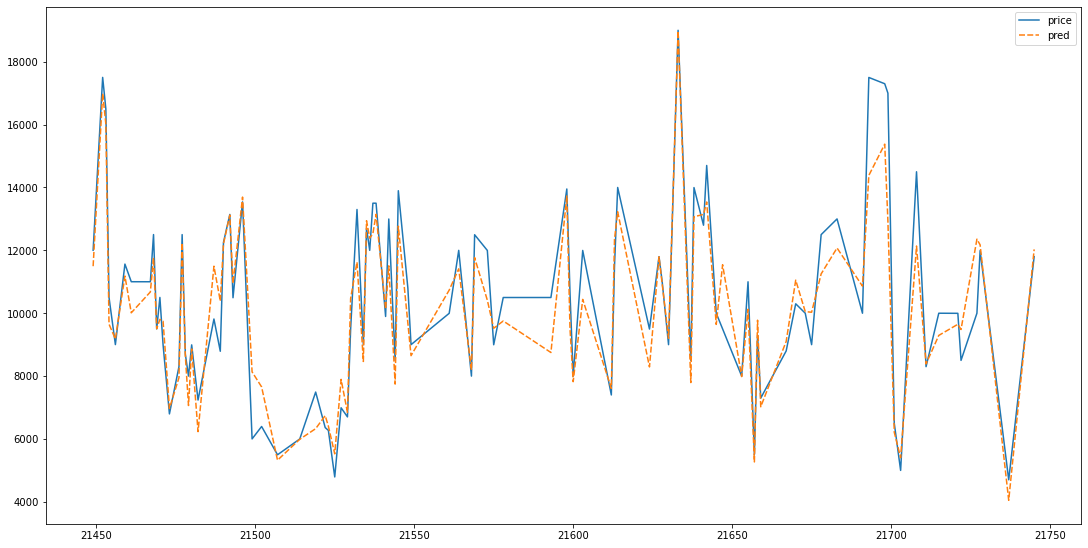

In [80]:
ax = t.get_ax(0.5)
# _ = sns.lineplot(ax=ax, data=df_y.sample(frac=0.1))
_ = sns.lineplot(ax=ax, data=df_y.iloc[:100])

In [ ]:
cv = RepeatedKFold(n_splits=8, n_repeats=10)
models_and_params = [
    (LinearRegression, {}),
    *[ (Ridge, {'random_state': RS, 'alpha' : a}) for a in [0.025, 0.05] ],
]

metrics = [r2_score]

In [ ]:
%%time

all_res = []
res_count = 0

for i_degree in range(3, 6):
    X_poly = m.polynomialFeatures(X, i_degree)
    # X_poly[X_poly.columns] = scale(X_poly, with_mean=False)
    X_poly[X_poly.columns] = scale(minmax_scale(X_poly[X_poly.columns]))
    
    for k in range (50, min(X_poly.shape[1], 200)):
        for model in models_and_params:
            ss = SelectKBest(f_regression, k = k)
            X_poly_k = pd.DataFrame(data = ss.fit_transform(X_poly, y), columns = ss.get_feature_names_out(), index = X_poly.index)
            
            res = t.grid_exec(
                lambda model: m.cv_regression(model, cv, X_poly_k, y, metrics), 
                models_and_params, 
            )
            
            for r in res:                
                r['d'] = i_degree
                r['k'] = k
                
            all_res.extend(res)

            res_count += 1
            if res_count % 10 == 0:
                m.display_stats(
                    pd.DataFrame(all_res).groupby(['d', 'model']).apply(lambda df : df.sort_values(by='R2_mean', ascending=False).head(1)).sort_values(by='R2_mean', ascending=False)
                )

In [ ]:
df_plt_res = pd.DataFrame(all_res)
df_plt_res = df_plt_res.loc[df_plt_res['R2_mean'] > 0]

df_plt_res.groupby(['d']).head(2).head(5)

ax = t.get_ax(0.33)
for d in df_plt_res['d'].unique():
    df_plt = df_plt_res.loc[df_plt_res['d'] == d]
    _ = sns.lineplot(ax=ax, data = df_plt, x='k', y='R2_mean', label=d)